In [1]:
import torch
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()

In [2]:
input_size = 21
dataset = torch.eye(input_size) #each row is a different pattern
target = torch.eye(dataset.shape[0])

data_seed = 0
data_generator = torch.Generator()
sample_indexes = torch.arange(len(dataset))
dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                        shuffle=True, 
                        generator=data_generator)

test_dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                             batch_size = 21)
epochs=100
seed=42

### BTSP learning rule

In [3]:
network_config = ut.read_from_yaml('../optimize/data/20200830_EIANN_1_hidden_BTSP_config_A.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

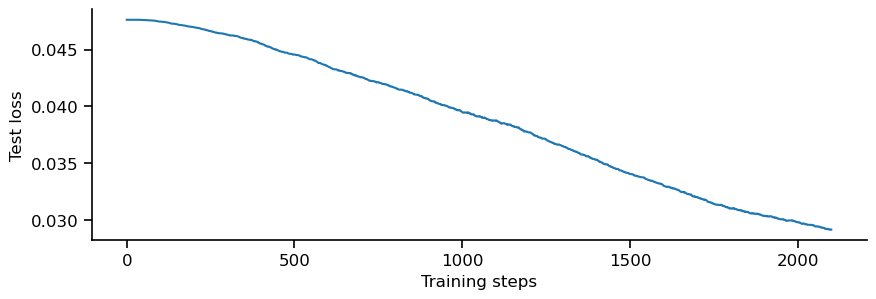

In [4]:
data_generator.manual_seed(data_seed)
btsp_network.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

pt.plot_test_loss_history(btsp_network, test_dataloader)

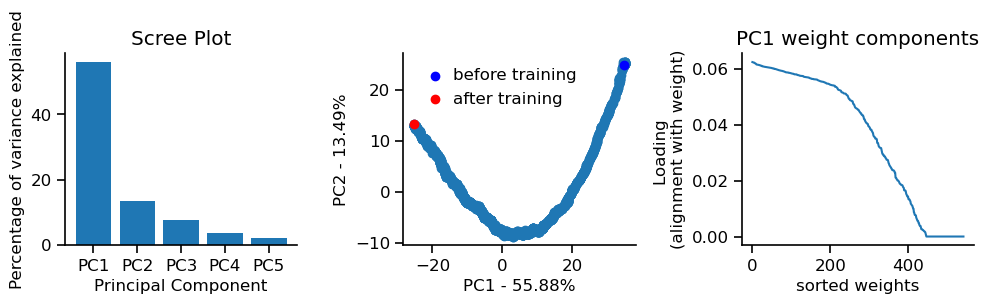

In [5]:
flat_param_history_btsp,_ = pt.get_flat_param_history(btsp_network.param_history)
pt.plot_param_history_PCs(flat_param_history_btsp)

  0%|          | 0/400 [00:00<?, ?it/s]

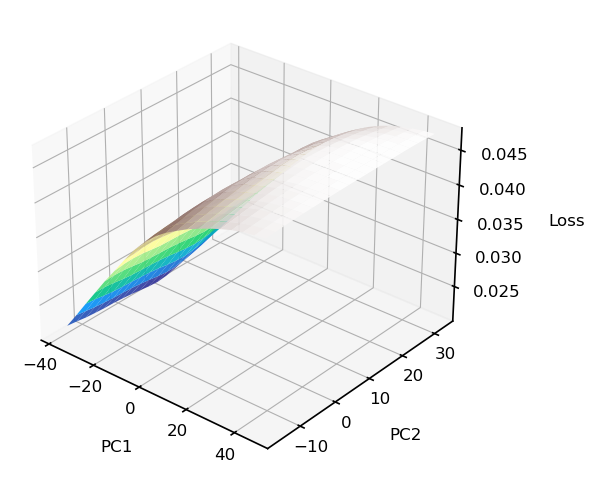

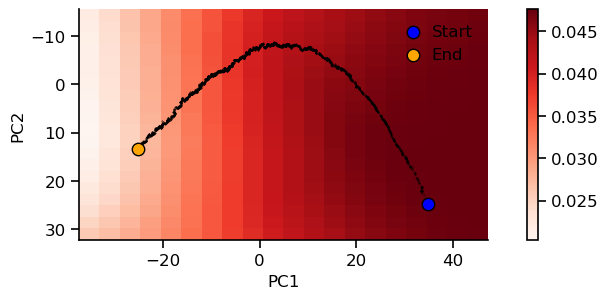

In [6]:
pt.plot_loss_landscape(test_dataloader, btsp_network, num_points=20)

In [7]:
def get_update_history(network):
    dParam_history = {name:[] for name in network.state_dict()}

    for i in range(len(network.param_history)-1):
        state_dict1 = network.param_history[i]
        state_dict2 = network.param_history[i+1]

        for param_name,param_val1,param_val2 in zip(state_dict1.keys(),state_dict1.values(),state_dict2.values()):
            d_param = param_val2 - param_val1
            dParam_history[param_name].append(d_param)

    for name,value in dParam_history.items():
        dParam_history[name] = torch.stack(value)
        
    return dParam_history

In [8]:
dParam_history = get_update_history(btsp_network)

for dW in dParam_history['module_dict.OutputE_H1E.weight']:
    for post_unit_updates in dW:
        if not (torch.all(post_unit_updates>=0) or torch.all(post_unit_updates<=0)):
            print(post_unit_updates)
        break

tensor([ 0.0000e+00,  7.9278e-05,  1.1303e-02, -1.7680e-05,  0.0000e+00,
         2.1228e-04,  0.0000e+00])
tensor([ 0.0000e+00,  5.7004e-05,  2.3163e-02, -1.3523e-05,  0.0000e+00,
         1.8201e-04,  0.0000e+00])
tensor([ 0.0000,  0.0000, -0.0007,  0.0000, -0.0005,  0.0002,  0.0000])
tensor([ 0.0000,  0.0000, -0.0007,  0.0000, -0.0005,  0.0008,  0.0000])
tensor([ 0.0000,  0.0000, -0.0007,  0.0000, -0.0006,  0.0010,  0.0000])
tensor([ 0.0000e+00,  0.0000e+00, -1.3947e-05,  0.0000e+00,  2.2952e-02,
         0.0000e+00,  0.0000e+00])
tensor([ 0.0000e+00,  0.0000e+00, -6.2108e-05,  0.0000e+00,  1.9479e-02,
         0.0000e+00,  0.0000e+00])
tensor([ 0.0000e+00,  0.0000e+00, -9.5844e-05,  0.0000e+00,  1.8839e-02,
         0.0000e+00,  0.0000e+00])


### Backprop (softplus; SGD)

In [9]:
network_config = ut.read_from_yaml('../config/EIANN_1_hidden_backpropDale_1_inh_softplus_SGD_config_B.yaml')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

In [10]:
# Initialize backprop net with same weights as BTSP init
btsp_initial_state = btsp_network.param_history[0]
btsp_initial_state = {key: btsp_initial_state[key] for key in bp_network.state_dict()}
bp_network.load_state_dict(btsp_initial_state)

<All keys matched successfully>

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

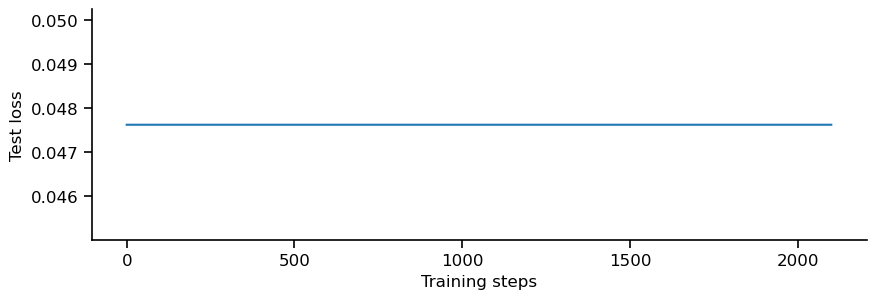

In [11]:
data_generator.manual_seed(data_seed)
bp_network.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

for layer in bp_network: #swap to ReLU activation to make loss comparable across networks
    for population in layer:
        population.activation = torch.nn.ReLU()
        
pt.plot_test_loss_history(bp_network, test_dataloader)

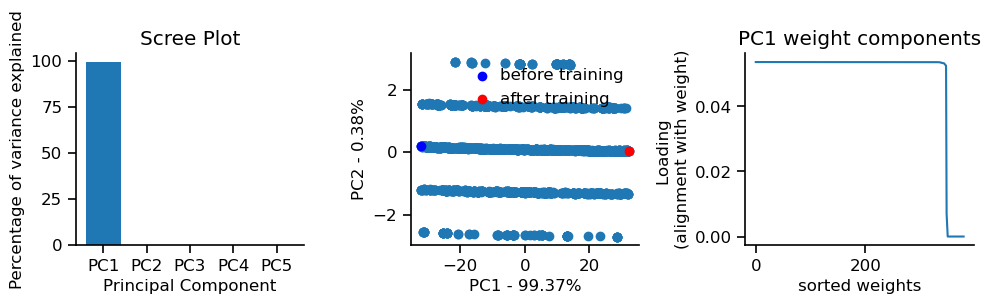

In [12]:
flat_param_history_bp,_ = pt.get_flat_param_history(bp_network.param_history)
pt.plot_param_history_PCs(flat_param_history_bp)

  0%|          | 0/400 [00:00<?, ?it/s]

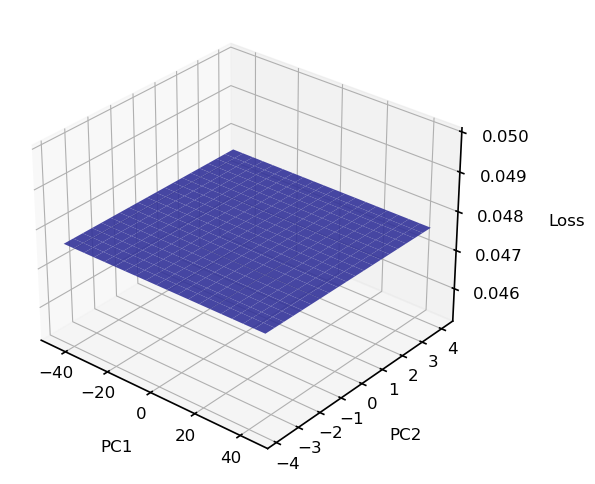

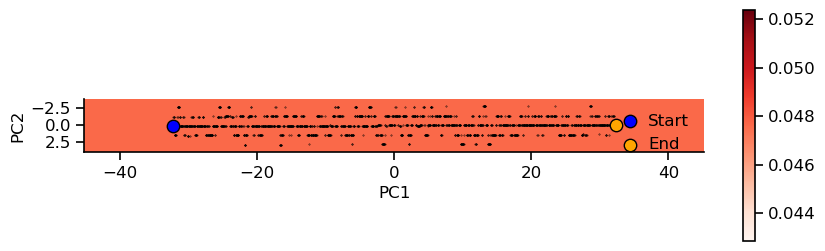

In [13]:
pt.plot_loss_landscape(test_dataloader, bp_network, num_points=20)

In [14]:
dParam_history = get_update_history(bp_network)

for dW in dParam_history['module_dict.OutputE_H1E.weight']:
    for post_unit_updates in dW:
        if not (torch.all(post_unit_updates>=0) or torch.all(post_unit_updates<=0)):
            print(post_unit_updates)
            break

## Combined loss landscape


In [15]:
bp_dict_keys = bp_network.state_dict().keys()
for i,state_dict in enumerate(btsp_network.param_history):
    state_dict_subset = {key: state_dict[key] for key in bp_dict_keys}
    btsp_network.param_history[i] = state_dict_subset

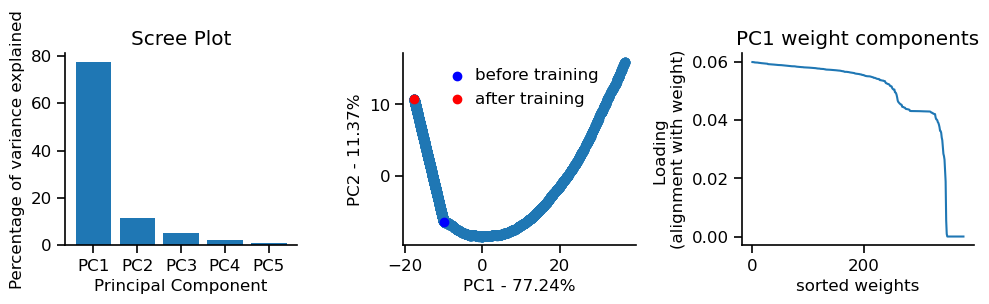

In [16]:
flat_param_history1,_ = pt.get_flat_param_history(btsp_network.param_history)
flat_param_history2,_ = pt.get_flat_param_history(bp_network.param_history)
combined_param_history = torch.cat([flat_param_history1,flat_param_history2])
pt.plot_param_history_PCs(combined_param_history)

  0%|          | 0/1600 [00:00<?, ?it/s]

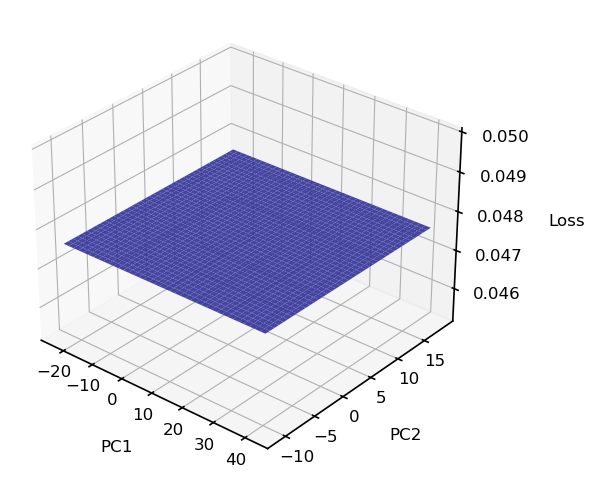

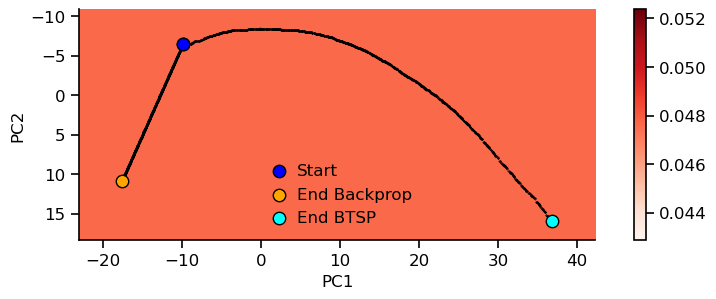

In [17]:
btsp_network.name = 'BTSP'
bp_network.name = 'Backprop'
pt.plot_loss_landscape(test_dataloader, bp_network, btsp_network, num_points=40, extension=0.1)